In [1]:
using Korg
using Trapz

In [2]:
"""
    linelist_neighbourhood_indices(linelist, ew_window_size)

Group lines together such that no two lines are closer than twice the value of `line_buffer`.

# Arguments:
- `linelist`: A vector of [`Line`](@ref)s (see [`read_linelist`](@ref), 
   [`get_APOGEE_DR17_linelist`](@ref), and [`get_VALD_solar_linelist`](@ref)).
- `ew_window_size`: the minimum separation (in Å) either side of lines in a group

# Returns
A vector of vectors, where each inner vector contains the indices of lines in a group.
"""
function linelist_neighbourhood_indices(linelist, ew_window_size)
    linelist_neighbourhood_indices = []        
    current_group = [1]    
    ew_window_size_overlap_cm = 2 * 1e-8 * ew_window_size
    for i in 2:length(linelist)
        if (linelist[i].wl - linelist[current_group[end]].wl) > ew_window_size_overlap_cm
            push!(current_group, i)
        else
            push!(linelist_neighbourhood_indices, current_group)
            current_group = [i]  
        end
    end
    push!(linelist_neighbourhood_indices, current_group)
    linelist_neighbourhood_indices
end

linelist_neighbourhood_indices

In [3]:

"""
    ews_to_abundances(atm, linelist, A_X, ews; kwargs... )

Compute per-line abundances given a model atmosphere and a list of lines with equivalent widths.

# Arguments:
- `atm`: the model atmosphere (see [`read_model_atmosphere`](@ref))
- `linelist`: A vector of [`Line`](@ref)s (see [`read_linelist`](@ref), 
   [`get_APOGEE_DR17_linelist`](@ref), and [`get_VALD_solar_linelist`](@ref)).
- `A_X`: a vector containing the A(X) abundances (log(X/H) + 12) for elements from hydrogen to 
  uranium.  (see [`format_A_X`](@ref))
- `ews`: a vector of equivalent widths (in mÅ)

# Returns
A vector of abundances (log10(n_X/n_H) + 12 format) for each line in `linelist`.

# Optional arguments:
- `vmic` (default: 1.0) is the microturbulent velocity, ``\\xi``, in km/s.
- `ew_window_size` (default: 2): the farthest (in Å) to consider equivalent width contributions for any line.
- `air_wavelengths` (default: `false`): Whether or not the input wavelengths are air wavelenths to 
   be converted to vacuum wavelengths by Korg.  The conversion will not be exact, so that the 
   wavelenth range can internally be represented by an evenly-spaced range.  If the approximation 
   error is greater than `wavelength_conversion_warn_threshold`, an error will be thrown. (To do 
   wavelength conversions yourself, see [`air_to_vacuum`](@ref) and [`vacuum_to_air`](@ref).)
- `wavelength_conversion_warn_threshold` (default: 1e-4): see `air_wavelengths`. (In Å.)
"""
function ews_to_abundances(atm, linelist, A_X, ews, ew_window_size::Real=2.0, λ_step=0.01; synthesize_kwargs...)

    synthesize_kwargs = Dict(synthesize_kwargs)
    if get(synthesize_kwargs, :hydrogen_lines, false)
        throw(ArgumentError("hydrogen_lines must be disabled"))
    end
    print(synthesize_kwargs)

    if !issorted(linelist; by=l->l.wl) 
        throw(ArgumentError("linelist must be sorted"))
    end

    if any(l -> Korg.ismolecule(l.species), linelist)
        throw(ArgumentError("linelist contains molecular species"))
    end

    # Check that the user is supplying EWs in mA
    if 1 > maximum(ews)
        @warn "Maximum EW given is less than 1 mA. Check that you're giving EWs in mA (*not* A)."
    end

    # Group lines together ensuring that no λ is closer to it's neighbour than twice the ew_window_size.
    group_indices = linelist_neighbourhood_indices(linelist, ew_window_size)

    d_A = Array{Float64}(undef, length(linelist))
    for indices in group_indices
        wl_ranges = map(linelist[indices]) do line
            λ_start, λ_stop = (1e8 * line.wl - ew_window_size, 1e8 * line.wl + ew_window_size)
            wls = range(λ_start, λ_stop; length=Int(round((λ_stop - λ_start)/λ_step))+1)
        end

        spectrum = Korg.synthesize(
            atm, linelist[indices], A_X, wl_ranges,
            hydrogen_lines=false;
            synthesize_kwargs...
        )

        for (i, (idx, line)) in enumerate(zip(spectrum.subspectra, linelist[indices]))
            depth = 1 .- spectrum.flux[idx] ./ spectrum.cntm[idx]
            ew = trapz(spectrum.wavelengths[idx], depth) # Angstrom
            rew = log10(ew / (line.wl * 1e8))    
            d_A[indices[i]] = rew - A_X[Korg.get_atoms(line.species)[1]] # species is atomic
        end
    end

    # measured EWs are in mA, factor of 10^11 converts from cm
    measured_REW = log10.(ews ./ [1e11 * line.wl for line in linelist])
    measured_REW .- d_A
end

ews_to_abundances

In [15]:
sun_ews = [74.3, 40.5, 96.1, 19.1, 80.7, 98.1, 72.1, 80.7, 86.9, 66.9, 65.9, 45.8, 30.3, 61.5, 41.3, 63.9, 61.5, 33.6, 26.7, 41.3, 79.4, 35.2, 43.7, 51.4, 52.0, 11.2, 50.2, 19.7, 77.6, 35.9, 18.9, 23.0, 59.6, 13.7, 84.7, 38.1, 22.9, 60.1, 55.5, 43.6, 77.9, 52.8, 68.2, 84.5, 23.0, 111.2, 64.0, 72.3, 117.3, 46.5, 34.0, 20.9, 30.8, 37.6, 49.9, 62.7, 45.4, 68.7, 47.6, 73.6, 82.7, 90.3, 30.1, 48.7, 52.9, 121.6, 85.9, 52.2, 24.6, 18.7, 53.2, 16.7, 40.5, 114.0, 42.4, 62.4, 46.5, 86.3, 44.7, 14.9, 129.9, 37.6, 46.3, 15.7, 21.2, 18.6, 47.4, 27.0, 12.4, 75.3, 36.8, 13.0, 35.4, 50.6, 18.9, 31.6, 63.3, 52.4,]
sco_ews = [74.8, 40.9, 97.5, 18.9, 84.0, 99.3, 72.5, 83.5, 88.3, 67.4, 66.3, 48.6, 31.0, 62.9, 42.7, 65.2, 62.9, 34.8, 28.5, 43.0, 81.3, 35.8, 45.8, 52.6, 53.8, 11.9, 51.8, 20.7, 78.8, 37.8, 20.3, 24.4, 61.7, 14.5, 86.4, 39.7, 23.8, 61.7, 55.4, 46.0, 79.1, 52.3, 70.3, 85.5, 23.9, 114.0, 65.7, 74.2, 118.8, 47.5, 35.3, 22.6, 32.8, 39.3, 51.2, 64.7, 47.4, 69.0, 49.4, 74.6, 83.9, 91.2, 31.5, 49.3, 54.6, 123.1, 86.9, 52.9, 25.3, 20.4, 54.3, 17.3, 42.6, 113.4, 43.9, 64.9, 47.2, 86.6, 46.2, 15.8, 132.8, 38.3, 47.9, 15.7, 22.3, 19.2, 48.4, 28.7, 13.2, 75.3, 39.0, 14.3, 35.8, 53.1, 20.0, 32.5, 64.1, 53.6,]
linelist = [
Korg.Line(5044.211 * 1e-8, -2.05800, Korg.Species("26.0"), 2.8512, 2.71e-31),
Korg.Line(5054.642 * 1e-8, -1.92100, Korg.Species("26.0"), 3.64, 4.68e-32),
Korg.Line(5127.359 * 1e-8, -3.30700, Korg.Species("26.0"), 0.915, 1.84e-32),
Korg.Line(5127.679 * 1e-8, -6.12500, Korg.Species("26.0"), 0.052, 1.2e-32),
Korg.Line(5197.577 * 1e-8, -2.22000, Korg.Species("26.1"), 3.2306, 8.69e-33),
Korg.Line(5198.711 * 1e-8, -2.13500, Korg.Species("26.0"), 2.223, 4.61e-32),
Korg.Line(5225.525 * 1e-8, -4.78900, Korg.Species("26.0"), 0.1101, 1.23e-32),
Korg.Line(5234.625 * 1e-8, -2.18000, Korg.Species("26.1"), 3.2215, 8.69e-33),
Korg.Line(5242.491 * 1e-8, -0.96700, Korg.Species("26.0"), 3.634, 4.95e-32),
Korg.Line(5247.050 * 1e-8, -4.94600, Korg.Species("26.0"), 0.0872, 1.22e-32),
Korg.Line(5250.208 * 1e-8, -4.93800, Korg.Species("26.0"), 0.1212, 1.23e-32),
Korg.Line(5264.812 * 1e-8, -3.13000, Korg.Species("26.1"), 3.2304, 9.43e-33),
Korg.Line(5295.312 * 1e-8, -1.49000, Korg.Species("26.0"), 4.415, 6.54e-31),
Korg.Line(5322.041 * 1e-8, -2.80000, Korg.Species("26.0"), 2.279, 4.29e-32),
Korg.Line(5325.553 * 1e-8, -3.16000, Korg.Species("26.1"), 3.2215, 8.57e-33),
Korg.Line(5373.709 * 1e-8, -0.77000, Korg.Species("26.0"), 4.473, 7.04e-31),
Korg.Line(5379.574 * 1e-8, -1.51400, Korg.Species("26.0"), 3.694, 5.02e-32),
Korg.Line(5386.334 * 1e-8, -1.74000, Korg.Species("26.0"), 4.154, 5.27e-31),
Korg.Line(5414.073 * 1e-8, -3.58000, Korg.Species("26.1"), 3.2215, 9.3e-33),
Korg.Line(5425.257 * 1e-8, -3.22000, Korg.Species("26.1"), 3.1996, 8.45e-33),
Korg.Line(5466.396 * 1e-8, -0.56500, Korg.Species("26.0"), 4.371, 4.4e-31),
Korg.Line(5466.987 * 1e-8, -2.23000, Korg.Species("26.0"), 3.573, 2.8),
Korg.Line(5522.446 * 1e-8, -1.31000, Korg.Species("26.0"), 4.209, 3.02e-31),
Korg.Line(5546.506 * 1e-8, -1.18000, Korg.Species("26.0"), 4.371, 3.91e-31),
Korg.Line(5560.211 * 1e-8, -1.16000, Korg.Species("26.0"), 4.434, 4.79e-31),
Korg.Line(5577.020 * 1e-8, -1.45500, Korg.Species("26.0"), 5.0331, 2.8),
Korg.Line(5618.633 * 1e-8, -1.27600, Korg.Species("26.0"), 4.209, 2.9e-31),
Korg.Line(5636.696 * 1e-8, -2.56000, Korg.Species("26.0"), 3.64, 5.19e-32),
Korg.Line(5638.262 * 1e-8, -0.81000, Korg.Species("26.0"), 4.22, 2.88e-31),
Korg.Line(5649.987 * 1e-8, -0.80000, Korg.Species("26.0"), 5.0995, 2.77e-31),
Korg.Line(5651.469 * 1e-8, -1.75000, Korg.Species("26.0"), 4.473, 4.83e-31),
Korg.Line(5661.348 * 1e-8, -1.75600, Korg.Species("26.0"), 4.2843, 3.24e-31),
Korg.Line(5679.023 * 1e-8, -0.75000, Korg.Species("26.0"), 4.652, 8.13e-31),
Korg.Line(5696.089 * 1e-8, -1.72000, Korg.Species("26.0"), 4.548, 5.78e-31),
Korg.Line(5701.544 * 1e-8, -2.21600, Korg.Species("26.0"), 2.559, 4.95e-32),
Korg.Line(5705.464 * 1e-8, -1.35500, Korg.Species("26.0"), 4.301, 3.02e-31),
Korg.Line(5855.076 * 1e-8, -1.47800, Korg.Species("26.0"), 4.6075, 5.74e-31),
Korg.Line(5905.672 * 1e-8, -0.69000, Korg.Species("26.0"), 4.652, 6.23e-31),
Korg.Line(5916.247 * 1e-8, -2.93600, Korg.Species("26.0"), 2.453, 4.29e-32),
Korg.Line(5927.789 * 1e-8, -1.04000, Korg.Species("26.0"), 4.652, 6.07e-31),
Korg.Line(5934.655 * 1e-8, -1.07000, Korg.Species("26.0"), 3.928, 5.69e-31),
Korg.Line(5956.694 * 1e-8, -4.60500, Korg.Species("26.0"), 0.8589, 1.55e-32),
Korg.Line(5987.065 * 1e-8, -0.21200, Korg.Species("26.0"), 4.795, 1.55e-32),
Korg.Line(6003.012 * 1e-8, -1.06000, Korg.Species("26.0"), 3.881, 4.83e-31),
Korg.Line(6005.541 * 1e-8, -3.43000, Korg.Species("26.0"), 2.588, 2.8),
Korg.Line(6024.058 * 1e-8, -0.02000, Korg.Species("26.0"), 4.548, 3.88e-31),
Korg.Line(6027.050 * 1e-8, -1.09000, Korg.Species("26.0"), 4.0758, 2.8),
Korg.Line(6056.005 * 1e-8, -0.45000, Korg.Species("26.0"), 4.733, 6.79e-31),
Korg.Line(6065.482 * 1e-8, -1.53000, Korg.Species("26.0"), 2.6085, 4.71e-32),
Korg.Line(6079.009 * 1e-8, -1.10000, Korg.Species("26.0"), 4.652, 5.13e-31),
Korg.Line(6082.711 * 1e-8, -3.57300, Korg.Species("26.0"), 2.223, 3.27e-32),
Korg.Line(6084.111 * 1e-8, -3.79000, Korg.Species("26.1"), 3.1996, 7.87e-33),
Korg.Line(6093.644 * 1e-8, -1.30000, Korg.Species("26.0"), 4.607, 4.41e-31),
Korg.Line(6096.665 * 1e-8, -1.81000, Korg.Species("26.0"), 3.9841, 5.75e-31),
Korg.Line(6151.618 * 1e-8, -3.29900, Korg.Species("26.0"), 2.1759, 2.55e-32),
Korg.Line(6157.728 * 1e-8, -1.22000, Korg.Species("26.0"), 4.076, 2.8),
Korg.Line(6165.360 * 1e-8, -1.46000, Korg.Species("26.0"), 4.1426, 2.8),
Korg.Line(6173.335 * 1e-8, -2.88000, Korg.Species("26.0"), 2.223, 2.65e-32),
Korg.Line(6187.990 * 1e-8, -1.67000, Korg.Species("26.0"), 3.943, 4.9e-31),
Korg.Line(6200.313 * 1e-8, -2.43700, Korg.Species("26.0"), 2.6085, 4.58e-32),
Korg.Line(6213.430 * 1e-8, -2.52000, Korg.Species("26.0"), 2.2227, 2.62e-32),
Korg.Line(6219.281 * 1e-8, -2.43300, Korg.Species("26.0"), 2.198, 2.58e-32),
Korg.Line(6226.736 * 1e-8, -2.10000, Korg.Species("26.0"), 3.883, 4.15e-31),
Korg.Line(6240.646 * 1e-8, -3.23300, Korg.Species("26.0"), 2.2227, 3.14e-32),
Korg.Line(6247.557 * 1e-8, -2.30000, Korg.Species("26.1"), 3.8918, 9.43e-33),
Korg.Line(6252.555 * 1e-8, -1.68700, Korg.Species("26.0"), 2.404, 3.84e-32),
Korg.Line(6265.134 * 1e-8, -2.55000, Korg.Species("26.0"), 2.1759, 2.48e-32),
Korg.Line(6270.225 * 1e-8, -2.54000, Korg.Species("26.0"), 2.858, 4.58e-32),
Korg.Line(6271.279 * 1e-8, -2.70300, Korg.Species("26.0"), 3.332, 2.78e-31),
Korg.Line(6369.462 * 1e-8, -4.11000, Korg.Species("26.1"), 2.8912, 7.42e-33),
Korg.Line(6380.743 * 1e-8, -1.37600, Korg.Species("26.0"), 4.186, 2.8),
Korg.Line(6392.539 * 1e-8, -4.03000, Korg.Species("26.0"), 2.279, 3.38e-32),
Korg.Line(6416.919 * 1e-8, -2.64000, Korg.Species("26.1"), 3.8918, 9.3e-33),
Korg.Line(6430.846 * 1e-8, -2.00600, Korg.Species("26.0"), 2.1759, 2.42e-32),
Korg.Line(6432.680 * 1e-8, -3.57000, Korg.Species("26.1"), 2.8912, 7.42e-33),
Korg.Line(6456.383 * 1e-8, -2.05000, Korg.Species("26.1"), 3.9036, 9.3e-33),
Korg.Line(6498.939 * 1e-8, -4.69900, Korg.Species("26.0"), 0.9581, 1.53e-32),
Korg.Line(6593.871 * 1e-8, -2.42200, Korg.Species("26.0"), 2.4326, 3.69e-32),
Korg.Line(6597.561 * 1e-8, -0.98000, Korg.Species("26.0"), 4.795, 4.76e-31),
Korg.Line(6625.022 * 1e-8, -5.33600, Korg.Species("26.0"), 1.011, 2.8),
Korg.Line(6677.987 * 1e-8, -1.41800, Korg.Species("26.0"), 2.692, 3.46e-32),
Korg.Line(6703.567 * 1e-8, -3.02300, Korg.Species("26.0"), 2.7585, 3.66e-32),
Korg.Line(6705.102 * 1e-8, -0.98000, Korg.Species("26.0"), 4.607, 2.8),
Korg.Line(6710.319 * 1e-8, -4.88000, Korg.Species("26.0"), 1.485, 2.01e-32),
Korg.Line(6713.745 * 1e-8, -1.40000, Korg.Species("26.0"), 4.795, 4.3e-31),
Korg.Line(6725.357 * 1e-8, -2.19000, Korg.Species("26.0"), 4.103, 4.82e-31),
Korg.Line(6726.667 * 1e-8, -1.03000, Korg.Species("26.0"), 4.607, 4.82e-31),
Korg.Line(6733.151 * 1e-8, -1.47000, Korg.Species("26.0"), 4.638, 3.41e-31),
Korg.Line(6739.522 * 1e-8, -4.79000, Korg.Species("26.0"), 1.557, 2.1e-32),
Korg.Line(6750.152 * 1e-8, -2.62100, Korg.Species("26.0"), 2.4241, 4.11e-32),
Korg.Line(6752.707 * 1e-8, -1.20400, Korg.Species("26.0"), 4.638, 3.37e-31),
Korg.Line(6793.259 * 1e-8, -2.32600, Korg.Species("26.0"), 4.076, 2.8),
Korg.Line(6806.845 * 1e-8, -3.11000, Korg.Species("26.0"), 2.727, 3.46e-32),
Korg.Line(6810.263 * 1e-8, -0.98600, Korg.Species("26.0"), 4.607, 4.5e-31),
Korg.Line(6837.006 * 1e-8, -1.68700, Korg.Species("26.0"), 4.593, 2.46e-32),
Korg.Line(6839.830 * 1e-8, -3.35000, Korg.Species("26.0"), 2.559, 3.95e-32),
Korg.Line(6843.656 * 1e-8, -0.86000, Korg.Species("26.0"), 4.548, 2.94e-31),
Korg.Line(6858.150 * 1e-8, -0.93000, Korg.Species("26.0"), 4.607, 3.24e-31),
]


98-element Vector{Korg.Line{Float64, Float64, Float64, Float64, Float64, Float64}}:
 Fe I 5044.211 Å (log gf = -2.06)
 Fe I 5054.642 Å (log gf = -1.92)
 Fe I 5127.359 Å (log gf = -3.31)
 Fe I 5127.679 Å (log gf = -6.12)
 Fe II 5197.577 Å (log gf = -2.22)
 Fe I 5198.711 Å (log gf = -2.13)
 Fe I 5225.525 Å (log gf = -4.79)
 Fe II 5234.625 Å (log gf = -2.18)
 Fe I 5242.491 Å (log gf = -0.97)
 Fe I 5247.05 Å (log gf = -4.95)
 ⋮
 Fe I 6750.152 Å (log gf = -2.62)
 Fe I 6752.707 Å (log gf = -1.2)
 Fe I 6793.259 Å (log gf = -2.33)
 Fe I 6806.845 Å (log gf = -3.11)
 Fe I 6810.263 Å (log gf = -0.99)
 Fe I 6837.006 Å (log gf = -1.69)
 Fe I 6839.83 Å (log gf = -3.35)
 Fe I 6843.656 Å (log gf = -0.86)
 Fe I 6858.15 Å (log gf = -0.93)

In [17]:
sun_Teff, sun_logg, sun_Fe_H, sun_vmic = (5777, 4.44, 0.0, 1.0)
sun_A_X = Korg.format_A_X(sun_Fe_H)
sun_atm = Korg.interpolate_marcs(sun_Teff, sun_logg, sun_A_X)  

Korg.PlanarAtmosphere{Float64, Float64, Float64, Float64, Float64} with 56 layers

In [18]:
sun_abundances = ews_to_abundances(sun_atm, linelist, sun_A_X, sun_ews, vmic=sun_vmic)

Dict(:vmic => 1.0)

98-element Vector{Float64}:
 7.479169248395722
 7.42422088320283
 7.453836094025727
 7.518756031140042
 7.449436255471412
 7.472167707919682
 7.467507615372016
 7.437432279689002
 7.437034600822892
 7.467908397052503
 ⋮
 7.480277478264499
 7.45799666672377
 7.415195976053855
 7.471598554686933
 7.469934194295676
 7.462095970222552
 7.465813480926904
 7.491052826329605
 7.459922598826152

In [19]:
sco_teff, sco_logg, sco_fe_h, sco_vmic = (5823, 4.45, 0.054, sun_vmic + 0.02)
sco_A_X = Korg.format_A_X(sco_fe_h)
sco_atm = Korg.interpolate_marcs(sco_teff, sco_logg, sco_A_X)

Korg.PlanarAtmosphere{Float64, Float64, Float64, Float64, Float64} with 56 layers

In [20]:
sco_abundances = ews_to_abundances(sco_atm, linelist, sco_A_X, sco_ews, vmic=sco_vmic)

Dict(:vmic => 1.02)

98-element Vector{Float64}:
 7.529973019104721
 7.470711432117186
 7.512192580370535
 7.572202045199583
 7.507771283840694
 7.527727790776761
 7.522140471261856
 7.493346955491436
 7.491546246375232
 7.52361883729134
 ⋮
 7.528118859421525
 7.519031901101107
 7.488382972388841
 7.5198540154219975
 7.5301469591914705
 7.516778564995187
 7.521734066326606
 7.537883276141557
 7.509715973058099

0.05445432477428866 0.005710106505793701

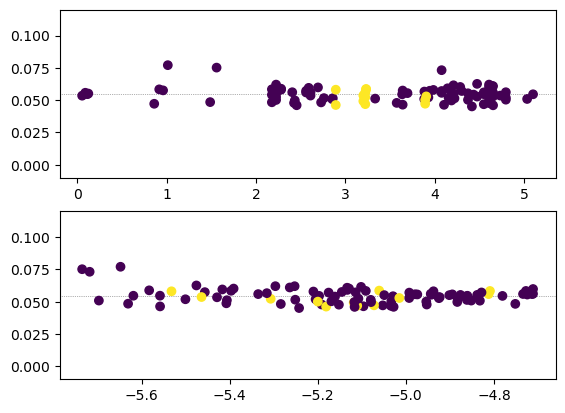

In [33]:
using PyPlot

x = [l.E_lower for l in linelist]
y = sco_abundances .- sun_abundances

print(Statistics.mean(y), " ", Statistics.std(y))
fig, axes = plt.subplots(2, 1)
axes[1].scatter(
    x,
    y,
    c=[l.species.charge for l in linelist]
)

x2 = log10.(ews ./ [l.wl * 1e11 for l in linelist])
axes[2].scatter(
    x2,
    y,
    c=[l.species.charge for l in linelist]
)
for ax in axes
    ax.axhline(Statistics.mean(y), c="#666666", ls=":", zorder=-1, lw=0.5)
    ax.set_ylim(-0.01, 0.12)
end
gcf()


In [37]:
println("wl,charge,E_lower,log_gf,sun_A,sco_A")
for (l, this_ew_sun, this_ew_sco, sun_a, sco_a) in zip(linelist, ew_sun, ew_sco, sun_abundances, sco_abundances)
    println("$(l.wl * 1e8),$(l.species.charge),$(l.E_lower),$(l.log_gf),$(this_ew_sun),$(this_ew_sco),$(sun_a),$(sco_a)")
end

wl,charge,E_lower,log_gf,sun_A,sco_A
5044.211,0,2.8512,-2.058,7.479169248395722,7.529973019104721
5054.642,0,3.64,-1.921,7.42422088320283,7.470711432117186
5127.359,0,0.915,-3.307,7.453836094025727,7.512192580370535
5127.679,0,0.052,-6.125,7.518756031140042,7.572202045199583
5197.577,1,3.2306,-2.22,7.449436255471412,7.507771283840694
5198.711,0,2.223,-2.135,7.472167707919682,7.527727790776761
5225.525,0,0.1101,-4.789,7.467507615372016,7.522140471261856
5234.625,1,3.2215,-2.18,7.437432279689002,7.493346955491436
5242.491,0,3.634,-0.967,7.437034600822892,7.491546246375232
5247.05,0,0.0872,-4.946,7.467908397052503,7.52361883729134
5250.208,0,0.1212,-4.938,7.468462228172721,7.523549731212426
5264.812,1,3.2304,-3.13,7.463067397365523,7.521688102195352
5295.312,0,4.415,-1.49,7.450385521509658,7.495516481119322
5322.041,0,2.279,-2.8,7.442004412171927,7.50011054365551
5325.553,1,3.2215,-3.16,7.425404512867942,7.472310796058451
5373.709,0,4.473,-0.77,7.4648873902940975,7.517643825040995
5379.57

In [14]:
using Statistics

(Statistics.mean(abundances), Statistics.std(abundances), Statistics.std(abundances) / sqrt(length(abundances) - 1))

(7.461145544497993, 0.029317665074072078, 0.0029767578803630928)

In [8]:
linelist[1].species.charge

0

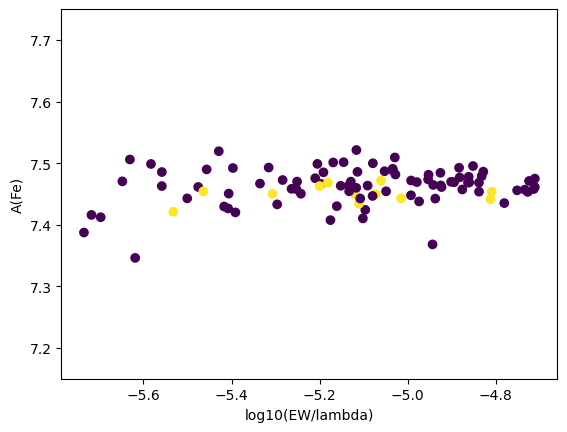

In [9]:
using PyPlot

x = log10.(ews ./ [l.wl * 1e11 for l in linelist])
fig, ax = plt.subplots()
ax.scatter(
    x,
    abundances,
    #c=[l.E_lower for l in linelist]
    c=[l.species.charge for l in linelist]
)
ax.set_xlabel("log10(EW/lambda)")
ax.set_ylabel("A(Fe)")
ax.set_ylim(7.45 - 0.3, 7.45 + 0.3)
gcf()